In [ ]:
%pip install pandas
%pip install pydmd
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install keras_tuner
%pip install keras

In [ ]:
import gc

from src.filler import dmd_filler, interpolate_filler, fill_df
from src.dataframe import read_data, windowing, split_data, show_error_metrics
from src.scaler import Scaler
from src.model import train_model, hp_search
from src.model import hp_search, build_model
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping
import keras

import numpy as np
from pydmd import DMD

In [ ]:
def forecast(city, filler_name, filler):
    name = f'{filler_name}_lstm_5_1_{city}'
    
    # read
    file = f'../data/daily_{city}.csv'
    df = read_data(file)
    df = fill_df(df, filler)
    
    # scaler
    scaler = Scaler(df)
    df_scaled = scaler.get_dataframe_scaled()
    
    # windowing
    X, Y = windowing(df_scaled, 5, 1)
    train_x, train_y, test_x, test_y = split_data(X, Y, length=len(df_scaled), ratio=0.9)
    
    hp = hp_search(name,
                   train_x,
                   train_y,
                   max_trials=20,
                   executions_per_trial=2,
                   epochs=20,
                   validation_split=0.3,
                   directory='fast_test',
                   verbose=1)
    
    model = build_model(hp)
    print('Hyperparameters: ', hp.values)
    
    # fit network
    model = build_model(hp)
    
    # fit network
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
    history = model.fit(train_x,
                        train_y,
                        epochs=200,
                        batch_size=72,
                        #validation_data=(test_x, test_y),
                        validation_split=0.3,
                        verbose=2,
                        callbacks=[es],
                        workers=4,
                        use_multiprocessing=True)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    
    # predict
    predict = model.predict(test_x)
    real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
    predict = scaler.scales['RADIATION'].inverse_transform(predict)
    
    # show predict
    range_plot = 100
    pyplot.plot(real[0:range_plot], color='blue', label='real')
    pyplot.plot(predict[0:range_plot], color='red', label='incompleto')
    pyplot.show()
    
    show_error_metrics(real, predict)

In [ ]:
city = 'barbacena'
filler = 'interpolate'
name = f'{filler}_lstm_5_1_{city}'

# read
file = f'../data/daily_{city}.csv'
df = read_data(file)
df = fill_df(df, interpolate_filler)

# scaler
scaler = Scaler(df)
df_scaled = scaler.get_dataframe_scaled()

# windowing
X, Y = windowing(df_scaled, 5, 1)
train_x, train_y, test_x, test_y = split_data(X, Y, length=len(df_scaled), ratio=0.9)

hp = hp_search(name,
               train_x,
               train_y,
               max_trials=20,
               executions_per_trial=2,
               epochs=20,
               validation_split=0.3,
               directory='fast_test',
               verbose=1)

model = build_model(hp)
print('Hyperparameters: ', hp.values)

# fit network
model = build_model(hp)

# fit network
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(train_x,
                    train_y,
                    epochs=200,
                    batch_size=72,
                    #validation_data=(test_x, test_y),
                    validation_split=0.3,
                    verbose=2,
                    callbacks=[es],
                    workers=4,
                    use_multiprocessing=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()


# predict
predict = model.predict(test_x)
real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

# show predict
range_plot = 100
pyplot.plot(real[0:range_plot], color='blue', label='real')
pyplot.plot(predict[0:range_plot], color='red', label='incompleto')
pyplot.show()

show_error_metrics(real, predict)

In [ ]:
fillers = {
    'interpolate': interpolate_filler,
    'dmd': dmd_filler
}

cities = [
    'barbacena',
    'juiz de fora',
    'muriae',
    'sao joao del rei',
    'vicosa'
]


for city in cities:
    for filler in fillers:
        print(f'=== {city} === {filler} ===')
        forecast(city, filler, fillers[filler])
        print('\n\n\n')

/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function sum at 0x7fda60b938b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function mean at 0x7fda60b96d30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Hyperparameters:  {'units': 32, 'dropout': 0.05, 'units_2': 512, 'activation': 'sigmoid', 'learning_rate': 0.01}
Epoch 1/200
64/64 - 4s - loss: 0.0380 - val_loss: 0.0269 - 4s/epoch - 69ms/step
Epoch 2/200
64/64 - 1s - loss: 0.0279 - val_loss: 0.0219 - 960ms/epoch - 15ms/step
Epoch 3/200
64/64 - 1s - loss: 0.0244 - val_loss: 0.0231 - 993ms/epoch - 16ms/step
Epoch 4/200
64/

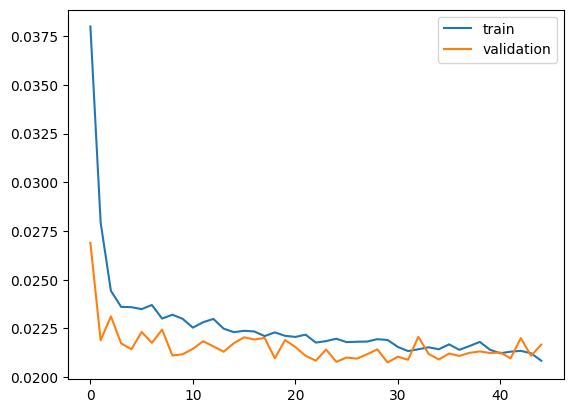

23/23 [==============================] - 1s 5ms/step


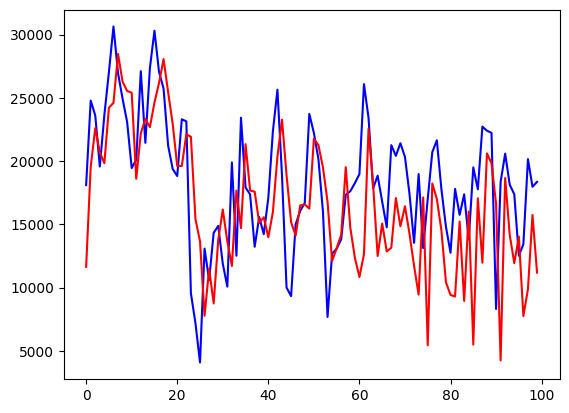

Test R2: 0.015
Test MSE: 39781336.365
Test RMSE: 6307.245
Test MAE: 5058.561
Test MAPE: 12659036350780506.000


In [12]:
forecast('barbacena', 'dmd', dmd_filler)

/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function sum at 0x7fda60b938b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function mean at 0x7fda60b96d30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Hyperparameters:  {'units': 32, 'dropout': 0.05, 'units_2': 512, 'activation': 'sigmoid', 'learning_rate': 0.01}
Epoch 1/200
50/50 - 4s - loss: 0.0387 - val_loss: 0.0313 - 4s/epoch - 76ms/step
Epoch 2/200
50/50 - 1s - loss: 0.0287 - val_loss: 0.0257 - 746ms/epoch - 15ms/step
Epoch 3/200
50/50 - 1s - loss: 0.0266 - val_loss: 0.0249 - 769ms/epoch - 15ms/step
Epoch 4/200
50/

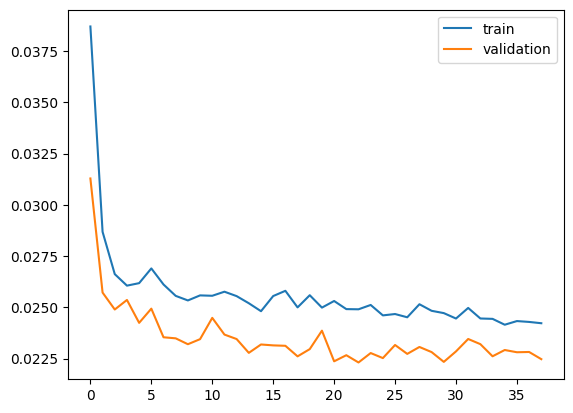

18/18 [==============================] - 1s 5ms/step


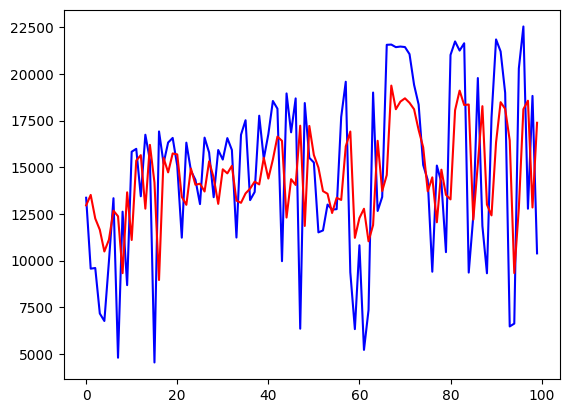

Test R2: 0.291
Test MSE: 24058785.530
Test RMSE: 4904.976
Test MAE: 3903.198
Test MAPE: 0.347


In [13]:
forecast('juiz de fora', 'dmd', dmd_filler)

/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function sum at 0x7fda60b938b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function mean at 0x7fda60b96d30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Hyperparameters:  {'units': 288, 'dropout': 0.25, 'units_2': 416, 'activation': 'sigmoid', 'learning_rate': 0.01}
Epoch 1/200
53/53 - 4s - loss: 0.0529 - val_loss: 0.0493 - 4s/epoch - 76ms/step
Epoch 2/200
53/53 - 1s - loss: 0.0403 - val_loss: 0.0403 - 829ms/epoch - 16ms/step
Epoch 3/200
53/53 - 1s - loss: 0.0361 - val_loss: 0.0295 - 799ms/epoch - 15ms/step
Epoch 4/200
53

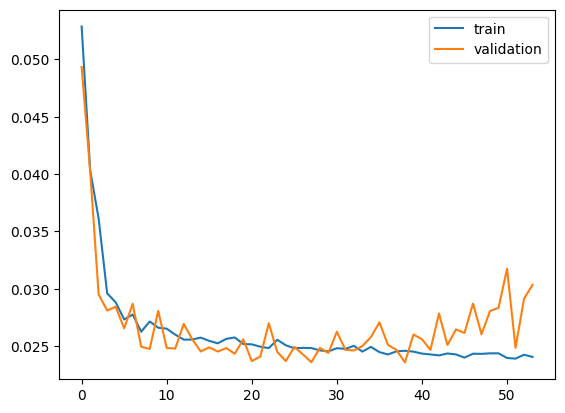

19/19 [==============================] - 1s 4ms/step


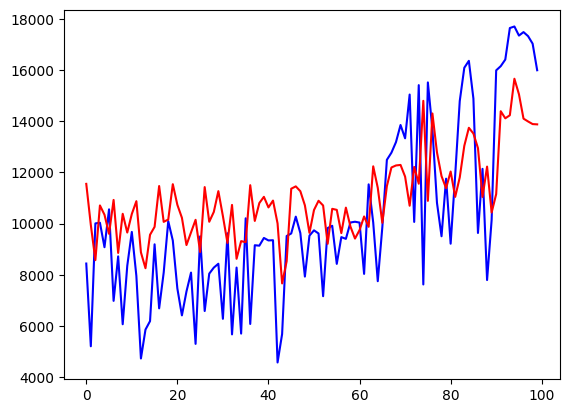

Test R2: 0.406
Test MSE: 21742251.220
Test RMSE: 4662.859
Test MAE: 3556.156
Test MAPE: 961244547633792128.000


In [14]:
forecast('muriae', 'dmd', dmd_filler)

/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function sum at 0x7fda60b938b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function mean at 0x7fda60b96d30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Hyperparameters:  {'units': 256, 'dropout': 0.1, 'units_2': 288, 'activation': 'sigmoid', 'learning_rate': 0.001}
Epoch 1/200
53/53 - 4s - loss: 0.0352 - val_loss: 0.0308 - 4s/epoch - 83ms/step
Epoch 2/200
53/53 - 1s - loss: 0.0291 - val_loss: 0.0264 - 767ms/epoch - 14ms/step
Epoch 3/200
53/53 - 1s - loss: 0.0255 - val_loss: 0.0235 - 803ms/epoch - 15ms/step
Epoch 4/200
53

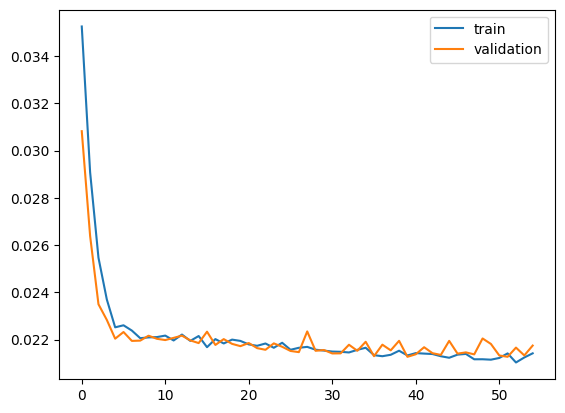

19/19 [==============================] - 1s 5ms/step


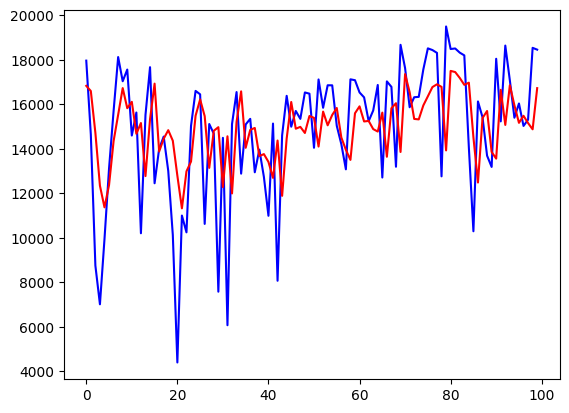

Test R2: 0.286
Test MSE: 19596756.219
Test RMSE: 4426.822
Test MAE: 3393.997
Test MAPE: 0.258


In [15]:
forecast('sao joao del rei', 'dmd', dmd_filler)

/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function sum at 0x7fda60b938b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function mean at 0x7fda60b96d30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Hyperparameters:  {'units': 32, 'dropout': 0.05, 'units_2': 512, 'activation': 'sigmoid', 'learning_rate': 0.01}
Epoch 1/200
56/56 - 4s - loss: 0.0335 - val_loss: 0.0277 - 4s/epoch - 66ms/step
Epoch 2/200
56/56 - 1s - loss: 0.0262 - val_loss: 0.0249 - 785ms/epoch - 14ms/step
Epoch 3/200
56/56 - 1s - loss: 0.0241 - val_loss: 0.0265 - 845ms/epoch - 15ms/step
Epoch 4/200
56/

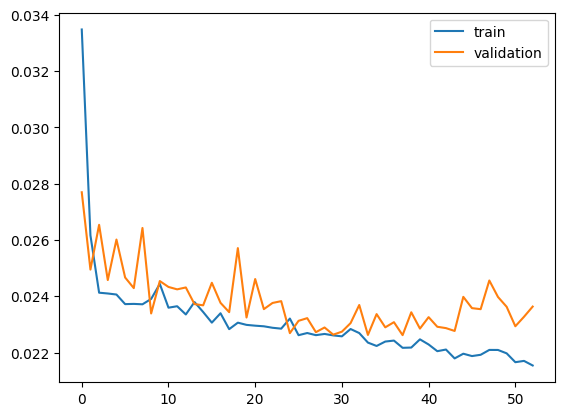

20/20 [==============================] - 1s 5ms/step


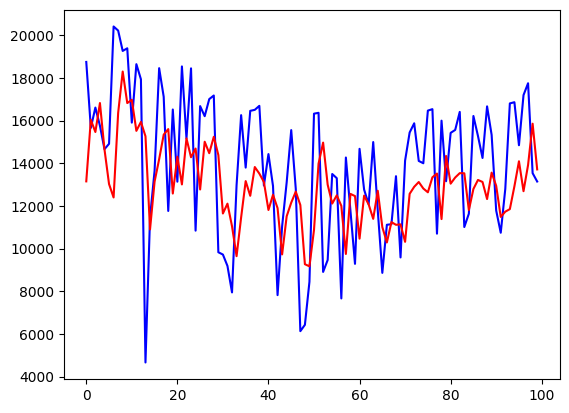

Test R2: 0.283
Test MSE: 19059092.404
Test RMSE: 4365.672
Test MAE: 3408.861
Test MAPE: 113160735783774912.000


In [16]:
forecast('vicosa', 'dmd', dmd_filler)

/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function sum at 0x7fda60b938b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function mean at 0x7fda60b96d30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Hyperparameters:  {'units': 256, 'dropout': 0.1, 'units_2': 288, 'activation': 'sigmoid', 'learning_rate': 0.001}
Epoch 1/200
64/64 - 4s - loss: 0.0305 - val_loss: 0.0273 - 4s/epoch - 68ms/step
Epoch 2/200
64/64 - 1s - loss: 0.0260 - val_loss: 0.0232 - 903ms/epoch - 14ms/step
Epoch 3/200
64/64 - 1s - loss: 0.0225 - val_loss: 0.0221 - 880ms/epoch - 14ms/step
Epoch 4/200
64

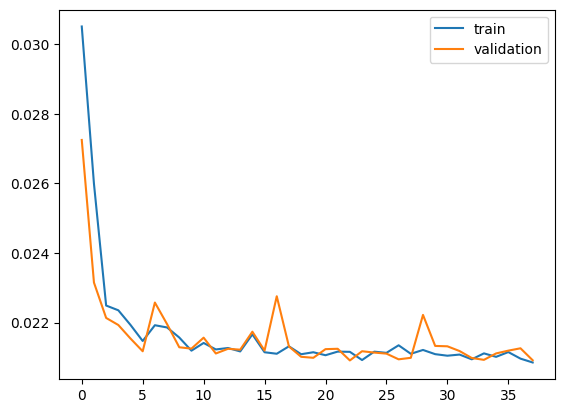

23/23 [==============================] - 1s 6ms/step


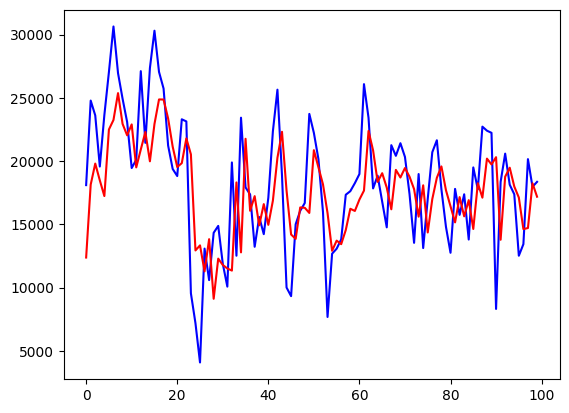

Test R2: 0.520
Test MSE: 18925372.615
Test RMSE: 4350.330
Test MAE: 3386.428
Test MAPE: 0.351


In [17]:
forecast('barbacena', 'interpolate', interpolate_filler)

/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function sum at 0x7fda60b938b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function mean at 0x7fda60b96d30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Hyperparameters:  {'units': 256, 'dropout': 0.1, 'units_2': 288, 'activation': 'sigmoid', 'learning_rate': 0.001}
Epoch 1/200
50/50 - 4s - loss: 0.0371 - val_loss: 0.0316 - 4s/epoch - 74ms/step
Epoch 2/200
50/50 - 1s - loss: 0.0319 - val_loss: 0.0266 - 752ms/epoch - 15ms/step
Epoch 3/200
50/50 - 1s - loss: 0.0268 - val_loss: 0.0236 - 713ms/epoch - 14ms/step
Epoch 4/200
50

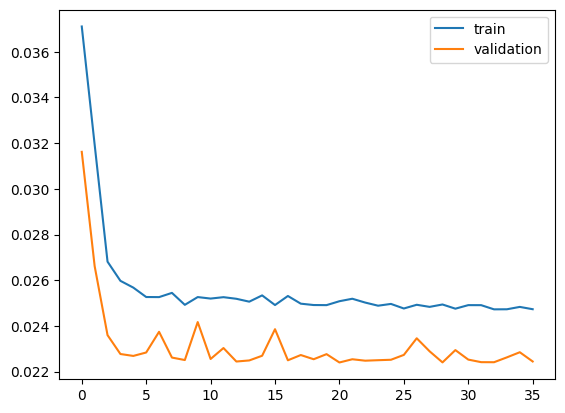

18/18 [==============================] - 1s 6ms/step


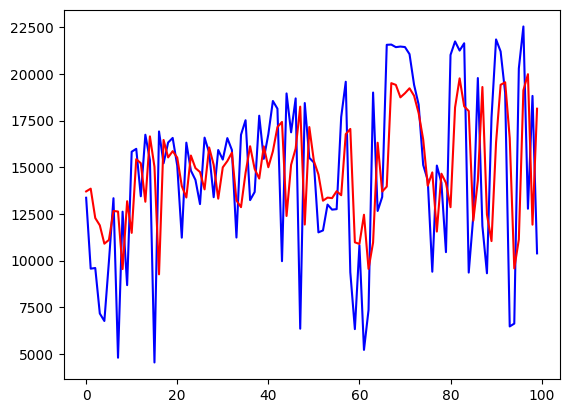

Test R2: 0.294
Test MSE: 23964810.502
Test RMSE: 4895.387
Test MAE: 3877.296
Test MAPE: 0.343


In [18]:
forecast('juiz de fora', 'interpolate', interpolate_filler)

/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function sum at 0x7fda60b938b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function mean at 0x7fda60b96d30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Hyperparameters:  {'units': 288, 'dropout': 0.25, 'units_2': 416, 'activation': 'sigmoid', 'learning_rate': 0.01}
Epoch 1/200
53/53 - 4s - loss: 0.0460 - val_loss: 0.0308 - 4s/epoch - 83ms/step
Epoch 2/200
53/53 - 1s - loss: 0.0335 - val_loss: 0.0243 - 825ms/epoch - 16ms/step
Epoch 3/200
53/53 - 1s - loss: 0.0280 - val_loss: 0.0303 - 772ms/epoch - 15ms/step
Epoch 4/200
53

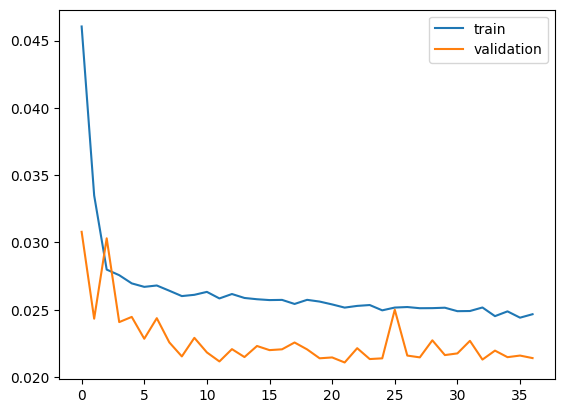

19/19 [==============================] - 1s 4ms/step


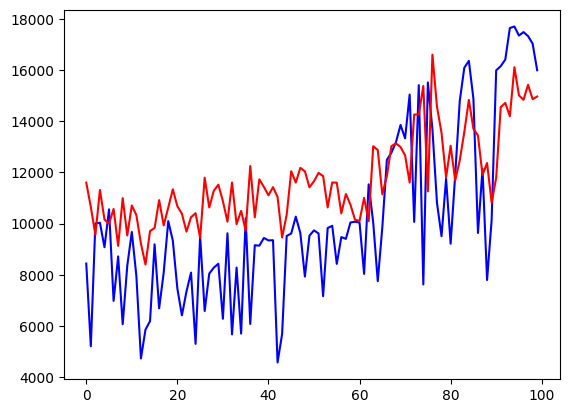

Test R2: 0.439
Test MSE: 18171644.831
Test RMSE: 4262.821
Test MAE: 3303.917
Test MAPE: 0.330


In [19]:
forecast('muriae', 'interpolate', interpolate_filler)

/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function sum at 0x7fda60b938b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function mean at 0x7fda60b96d30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Hyperparameters:  {'units': 256, 'dropout': 0.1, 'units_2': 288, 'activation': 'sigmoid', 'learning_rate': 0.001}
Epoch 1/200
53/53 - 4s - loss: 0.0307 - val_loss: 0.0296 - 4s/epoch - 75ms/step
Epoch 2/200
53/53 - 1s - loss: 0.0268 - val_loss: 0.0263 - 784ms/epoch - 15ms/step
Epoch 3/200
53/53 - 1s - loss: 0.0239 - val_loss: 0.0241 - 702ms/epoch - 13ms/step
Epoch 4/200
53

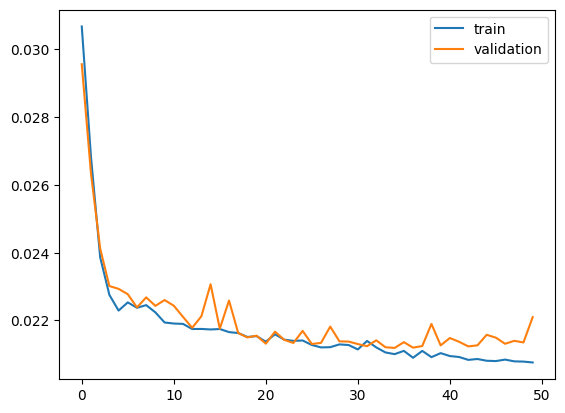

19/19 [==============================] - 1s 5ms/step


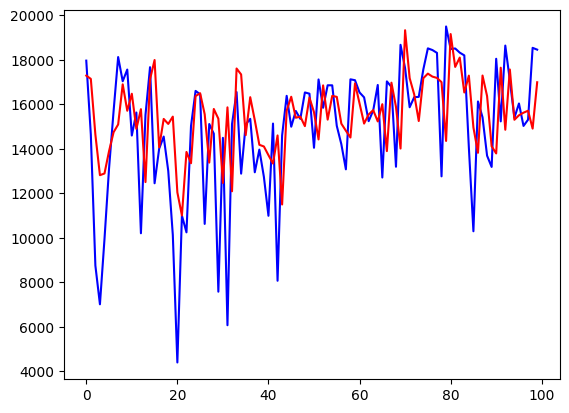

Test R2: 0.256
Test MSE: 20430592.878
Test RMSE: 4520.021
Test MAE: 3436.943
Test MAPE: 0.267


In [20]:
forecast('sao joao del rei', 'interpolate', interpolate_filler)

/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function sum at 0x7fda60b938b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/home/yurid/git/tcc/notebook/src/dataframe.py:19: FutureWarning: The provided callable <function mean at 0x7fda60b96d30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Hyperparameters:  {'units': 32, 'dropout': 0.05, 'units_2': 512, 'activation': 'sigmoid', 'learning_rate': 0.01}
Epoch 1/200
56/56 - 4s - loss: 0.0284 - val_loss: 0.0246 - 4s/epoch - 74ms/step
Epoch 2/200
56/56 - 1s - loss: 0.0234 - val_loss: 0.0234 - 855ms/epoch - 15ms/step
Epoch 3/200
56/56 - 1s - loss: 0.0230 - val_loss: 0.0235 - 787ms/epoch - 14ms/step
Epoch 4/200
56/

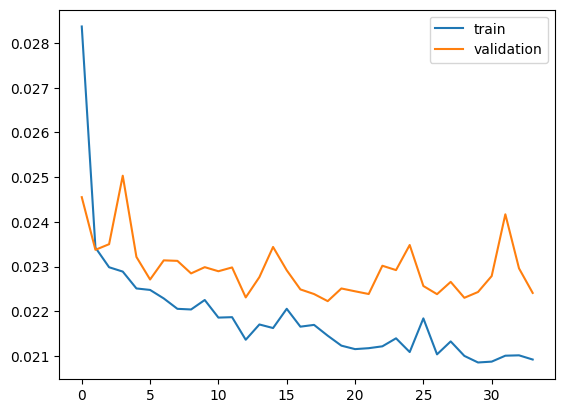

20/20 [==============================] - 1s 5ms/step


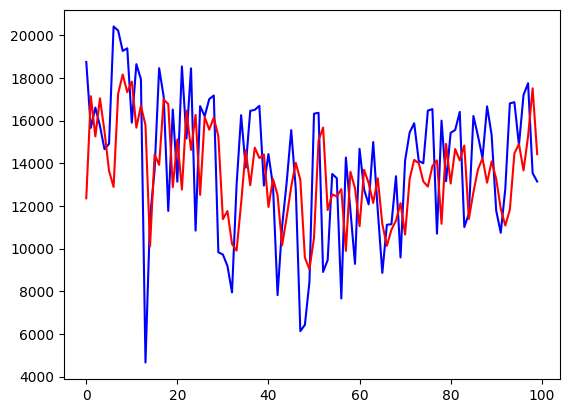

Test R2: 0.287
Test MSE: 18271830.885
Test RMSE: 4274.556
Test MAE: 3350.457
Test MAPE: 0.289


In [21]:
forecast('vicosa', 'interpolate', interpolate_filler)